In [1]:
import os
import shutil
from xml.etree import ElementTree

# Set paths
stop_dir = "./Datasets/Dataset/stop/"
not_stop_dir = "./Datasets/Dataset/not_stop/"
annotations_dir = "./Datasets/Stop_sign/annotations/"
images_dir = "./Datasets/Stop_sign/images/"

# Create directories
os.makedirs(stop_dir, exist_ok=True)
os.makedirs(not_stop_dir, exist_ok=True)

# Iterate over annotation files
for annotation_file in os.listdir(annotations_dir):
    # Parse XML
    xml = ElementTree.parse(os.path.join(annotations_dir, annotation_file))
    root = xml.getroot()

    # Check if image contains stop sign
    contains_stop_sign = False
    for obj in root.findall("object"):
        if obj.find("name").text == "stop":
            contains_stop_sign = True
            break

    # Copy image to appropriate directory
    try:
        if contains_stop_sign:
            shutil.copy2(os.path.join(images_dir, root.find("filename").text), stop_dir)
        else:
            shutil.copy2(os.path.join(images_dir, root.find("filename").text), not_stop_dir)
    except FileNotFoundError:
        print(f"Skipping {root.find('filename').text} because image file not found.")
##skipped images manualy copied to dataset

annotations_dir = "./Datasets/Dataset/annotations/"

Skipping IMG_0195.jpg because image file not found.
Skipping IMG_0188.jpg because image file not found.


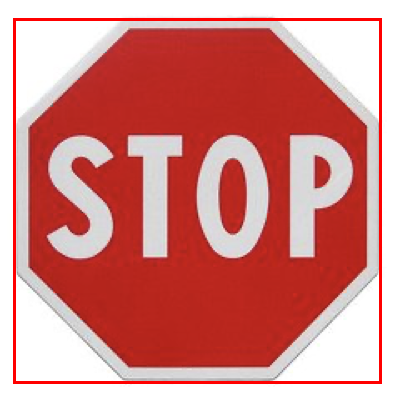

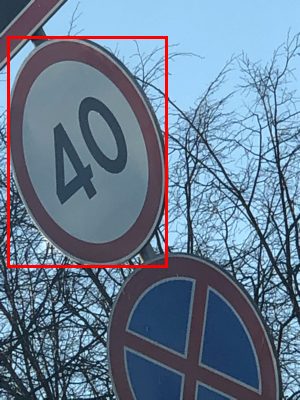

In [2]:
import os
import random
import shutil
from xml.etree import ElementTree
from PIL import Image, ImageDraw

# Define the path to the annotations folder
annotation_dir = "./Datasets/Stop_sign/annotations"

# Display a random stop sign image with bounding boxes
stop_images = os.listdir(stop_dir)
stop_image_path = os.path.join(stop_dir, random.choice(stop_images))
stop_image = Image.open(stop_image_path)

# Load the corresponding annotation file and extract the stop sign bounding boxes
annotation_path = os.path.join(annotation_dir, os.path.splitext(os.path.basename(stop_image_path))[0] + ".xml")
tree = ElementTree.parse(annotation_path)
root = tree.getroot()
stop_sign_bboxes = []
for obj in root.findall("object"):
    if obj.find("name").text == "stop":
        bbox = obj.find("bndbox")
        stop_sign_bboxes.append((
            int(bbox.find("xmin").text),
            int(bbox.find("ymin").text),
            int(bbox.find("xmax").text),
            int(bbox.find("ymax").text)
        ))

# Draw the bounding boxes on the stop sign image
draw = ImageDraw.Draw(stop_image)
for bbox in stop_sign_bboxes:
    draw.rectangle(bbox, outline="red", width=3)
display(stop_image)

# Display a random non-stop sign image with bounding boxes
not_stop_images = os.listdir(not_stop_dir)
not_stop_image_path = os.path.join(not_stop_dir, random.choice(not_stop_images))
not_stop_image = Image.open(not_stop_image_path)

# Load the corresponding annotation file and extract the non-stop sign bounding boxes
annotation_path = os.path.join(annotation_dir, os.path.splitext(os.path.basename(not_stop_image_path))[0] + ".xml")
tree = ElementTree.parse(annotation_path)
root = tree.getroot()
not_stop_sign_bboxes = []
for obj in root.findall("object"):
    if obj.find("name").text != "stop":
        bbox = obj.find("bndbox")
        not_stop_sign_bboxes.append((
            int(bbox.find("xmin").text),
            int(bbox.find("ymin").text),
            int(bbox.find("xmax").text),
            int(bbox.find("ymax").text)
        ))

# Draw the bounding boxes on the non-stop sign image
draw = ImageDraw.Draw(not_stop_image)
for bbox in not_stop_sign_bboxes:
    draw.rectangle(bbox, outline="red", width=3)
display(not_stop_image)


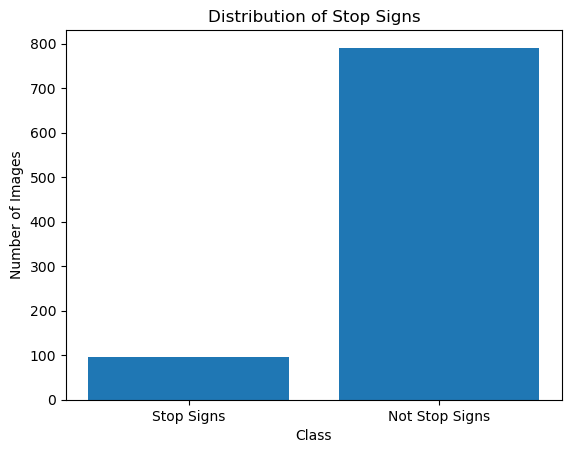

Number of stop sign images: 96
Number of non-stop sign images: 791


In [3]:
import matplotlib.pyplot as plt

# Count number of images in each directory
num_stop_images = len(os.listdir(stop_dir))
num_not_stop_images = len(os.listdir(not_stop_dir))

# Display bar graph
plt.bar(["Stop Signs", "Not Stop Signs"], [num_stop_images, num_not_stop_images])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Stop Signs")
plt.savefig('./figs/stop_sign_imbalanced_distribution.png')
plt.show()

# Display number of images in each directory
print(f"Number of stop sign images: {num_stop_images}")
print(f"Number of non-stop sign images: {num_not_stop_images}")

In [4]:
import os
from PIL import Image

# Define the directory containing the JPEG files
input_dir = "./Datasets/Dataset/not_stop/"

# Loop through all files in the input directory
for filename in os.listdir(input_dir):
    # Check if the file is a JPEG
    if filename.lower().endswith(".jpg") or filename.lower().endswith(".jpeg"):
        # Load the image and convert it to PNG format
        image_path = os.path.join(input_dir, filename)
        with Image.open(image_path) as im:
            im.convert("RGB").save(os.path.join(input_dir, filename.replace(".jpg", ".png")), "PNG")
        # Remove the original JPEG file
        os.remove(image_path)
        print(f"Converted and replaced {filename} with {filename.replace('.jpg', '.png')}")


In [5]:
import os
from PIL import Image

# Define the directory containing the JPEG files
input_dir = "./Datasets/Dataset/stop/"

# Loop through all files in the input directory
for filename in os.listdir(input_dir):
    # Check if the file is a JPEG
    if filename.lower().endswith(".jpg") or filename.lower().endswith(".jpeg"):
        # Load the image and convert it to PNG format
        image_path = os.path.join(input_dir, filename)
        with Image.open(image_path) as im:
            im.convert("RGB").save(os.path.join(input_dir, filename.replace(".jpg", ".png")), "PNG")
        # Remove the original JPEG file
        os.remove(image_path)
        print(f"Converted and replaced {filename} with {filename.replace('.jpg', '.png')}")


In [6]:
import os
import xml.etree.ElementTree as ET
from PIL import Image, ImageEnhance
from tqdm import tqdm
import numpy as np
import random

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array

# Define image data generator
datagen = ImageDataGenerator()

# Set random seed for reproducibility
random.seed(42)

# Augment stop sign images
stop_images = os.listdir(stop_dir)
num_augmented_images = 0

with tqdm(total=len(stop_images), desc="Augmenting Images") as pbar:
    for image_file in stop_images:
        # Load the image and its annotations
        image_path = os.path.join(stop_dir, image_file)
        img = Image.open(image_path)
        annotations_path = os.path.join(annotations_dir, image_file.replace(".png", ".xml"))
        tree = ET.parse(annotations_path)
        root = tree.getroot()

        # Extract the bounding boxes for the "stop" class
        bboxes = []
        for obj in root.findall("object"):
            if obj.find("name").text == "stop":
                bbox = obj.find("bndbox")
                bboxes.append([int(bbox.find(x).text) for x in ["xmin", "ymin", "xmax", "ymax"]])

        # Generate augmented images for each bounding box
        for bbox in bboxes:
            # Apply image transformations
            brightness = random.uniform(0.5, 1.5)
            contrast = random.uniform(0.5, 1.5)
            enhancer = ImageEnhance.Brightness(img)
            img_aug = enhancer.enhance(brightness)
            enhancer = ImageEnhance.Contrast(img_aug)
            img_aug = enhancer.enhance(contrast)

            # Crop the augmented image based on the bounding box
            xmin, ymin, xmax, ymax = bbox
            img_array = img_to_array(img_aug.crop((xmin, ymin, xmax, ymax)))
            img_array = img_array.reshape((1,) + img_array.shape)
            i = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=stop_dir, save_prefix="aug_", save_format="png"):
                i += 1
                num_augmented_images += 1
                pbar.update(1)
                if i >= 6:  # Augment each bounding box six times
                    break

            # Save the augmented images
            img_aug.save(os.path.join(stop_dir, f"aug_{num_augmented_images}.png"))

print(f"Number of augmented stop sign images: {num_augmented_images}")


Augmenting Images: 576it [00:07, 76.65it/s]                                     

Number of augmented stop sign images: 576


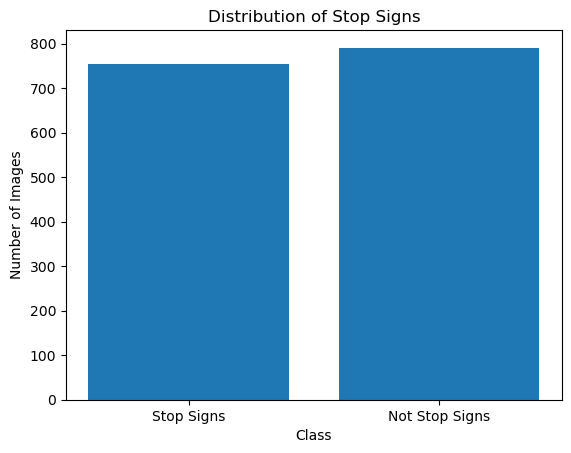

Number of stop sign images: 754
Number of non-stop sign images: 791


In [7]:
import matplotlib.pyplot as plt

# Count number of images in each directory
num_stop_images = len(os.listdir(stop_dir))
num_not_stop_images = len(os.listdir(not_stop_dir))

# Display bar graph
plt.bar(["Stop Signs", "Not Stop Signs"], [num_stop_images, num_not_stop_images])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Stop Signs")
plt.savefig('./figs/stop_sign_distribution.png')
plt.show()

# Display number of images in each directory
print(f"Number of stop sign images: {num_stop_images}")
print(f"Number of non-stop sign images: {num_not_stop_images}")


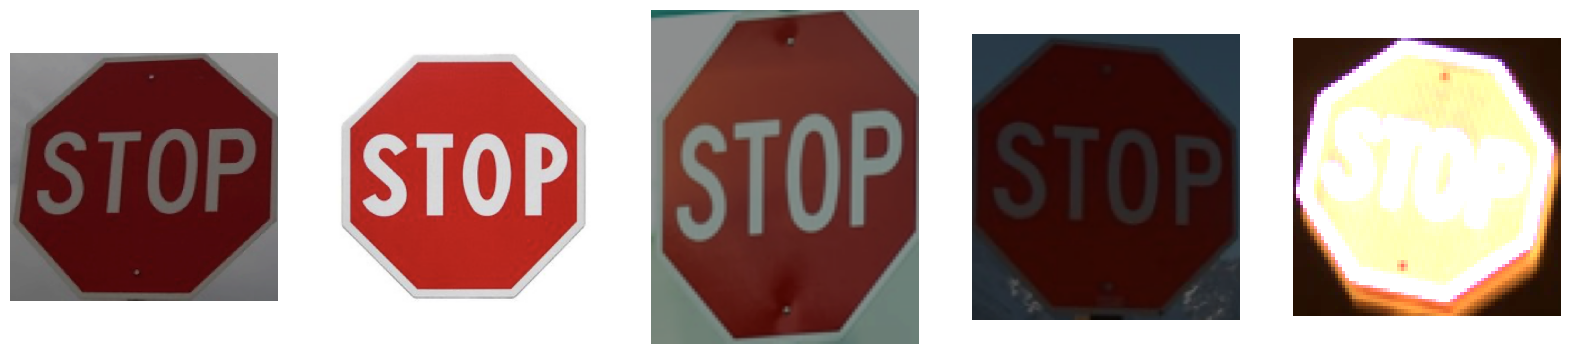

In [8]:
import matplotlib.pyplot as plt

# Display some augmented images
sample_images = random.sample(os.listdir(stop_dir), 5)
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, image_file in enumerate(sample_images):
    image_path = os.path.join(stop_dir, image_file)
    img = Image.open(image_path)
    axs[i].imshow(img)
    axs[i].axis("off")
plt.show()


In [9]:
import os
from PIL import Image
from tqdm import tqdm

# Define the directory paths
dataset_dir = "./Datasets/Dataset"
stop_dir = os.path.join(dataset_dir, "stop")
not_stop_dir = os.path.join(dataset_dir, "not_stop")

# Define the new size
new_size = (96, 96)

# Resize the stop images
stop_images = os.listdir(stop_dir)
with tqdm(total=len(stop_images), desc="Resizing Stop Images") as pbar:
    for file_name in stop_images:
        if file_name.endswith(".png"):
            image_path = os.path.join(stop_dir, file_name)
            img = Image.open(image_path)
            img = img.resize(new_size, resample=Image.LANCZOS)
            img.save(image_path)
        pbar.update(1)

# Resize the not_stop images
not_stop_images = os.listdir(not_stop_dir)
with tqdm(total=len(not_stop_images), desc="Resizing Not Stop Images") as pbar:
    for file_name in not_stop_images:
        if file_name.endswith(".png"):
            image_path = os.path.join(not_stop_dir, file_name)
            img = Image.open(image_path)
            img = img.resize(new_size, resample=Image.LANCZOS)
            img.save(image_path)
        pbar.update(1)


Resizing Stop Images:   0%|                             | 0/754 [00:00<?, ?it/s]/tmp/ipykernel_26093/2620169943.py:20: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(new_size, resample=Image.LANCZOS)
Resizing Not Stop Images:   0%|                         | 0/791 [00:00<?, ?it/s]/tmp/ipykernel_26093/2620169943.py:31: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(new_size, resample=Image.LANCZOS)
Resizing Not Stop Images: 100%|██████████████| 791/791 [00:07<00:00, 112.63it/s]


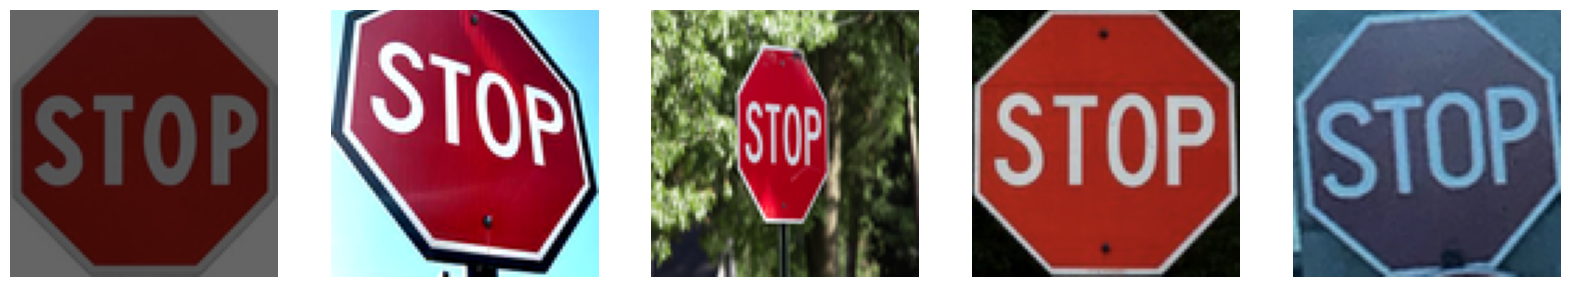

In [10]:
import matplotlib.pyplot as plt

# Display some augmented images
sample_images = random.sample(os.listdir(stop_dir), 5)
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, image_file in enumerate(sample_images):
    image_path = os.path.join(stop_dir, image_file)
    img = Image.open(image_path)
    axs[i].imshow(img)
    axs[i].axis("off")
plt.savefig('./figs/augmented_stop_sign_images.png')  # Save the figure before displaying it
plt.show()
